In [2]:
%load_ext autoreload
%autoreload 2
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import particle as pt
from anytree import Node, RenderTree
from scipy import stats
from scipy.optimize import curve_fit
import mplhep 
mplhep.style.use(mplhep.style.ROOT)
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.append('/home/henrique/Documents/Atmos_Pandora/apc_atmo_repo/personal/Henrique/')
from ana_tree_class import AnaTreeAnalyzer

# plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_theta_phi(dcosx, dcosy, dcosz):
    """ Return theta and phi from versors
    I am keeping the geant output of theta[0, pi] and phi[-pi,pi]
    """
    theta = np.arccos(dcosz)
    if dcosx == 0:
        phi = 0
        if dcosy == 0:
            pass
        elif dcosy > 0:
            phi = np.pi/2
        elif dcosy < 0:
            phi = -np.pi/2
        return theta, phi

    phi = np.arctan(dcosy/dcosx)
    if phi == 0:
        if (dcosx > 0):
            return theta, phi
        else:
            return theta, phi+np.pi
    if phi > 0:
        if dcosx > 0:
            return theta, phi
        else:
            return theta, phi-np.pi
    else: 
        if dcosx > 0:
            return theta, phi
        else:
            return theta, np.pi+phi

In [4]:
tree = uproot.open("./anatree_hd_AV_sum.root:analysistree/anatree")

In [5]:
ana = AnaTreeAnalyzer(file="./anatree_hd_AV_sum.root:analysistree/anatree")
ana.loadTree()

In [6]:
ana.add_track_geant_info()

In [7]:
data = ana.data
data_original = ana.data
# np.sum(data["inTPCActive_geant"]==1,axis=-1)
# data["geant_list_size_geant"] - data["geant_list_size_in_tpcAV_geant"]

In [8]:
def get_mother_muon(data_to_mask, pdgs):

    # Create an array of array with all False for the length of mothers particle
    some_mask = data_to_mask["Mother_geant"][data_to_mask["Mother_geant"] == 0] == -1

    for i,pdg in enumerate(pdgs):
        test = data_to_mask["pdg_geant"][data_to_mask["Mother_geant"] == 0] == pdg
        some_mask = some_mask | test

    

    return some_mask

In [52]:
maskmu = abs(data["nuPDG_truth"][:,0]) == 14
maskcc = data["ccnc_truth"][:,0] == 0

data_mu_primary = data[maskcc & maskmu]

# selecting only events fully contained in tpc:
mask_mother_mu = get_mother_muon(data_mu_primary, pdgs=[13,-13])
mask_valid_mu = []
for ev, m in zip(data_mu_primary, mask_mother_mu):
    test = ana.check_fiducial(ev, m, "geant")
    try:
        mask_valid_mu.append(test[0])
    except:
        mask_valid_mu.append(False)

    # mask_valid_mu.append(True)
    

n_numu_cc_events = len(data_mu_primary)

data_mu_primary_valid = data_mu_primary[mask_valid_mu]
n_numu_cc_events_mu_contained = len(data_mu_primary_valid)
data_bad_reco_mu = data_mu_primary_valid[data_mu_primary_valid["ntracks_pandoraTrack"] == 0]
data_bad_reco_mu = data_bad_reco_mu[data_bad_reco_mu["nshowers_pandoraShower"] == 0]

ana.data = data_bad_reco_mu
mu_without_tracks = abs(data_bad_reco_mu["pdg_geant"][data_bad_reco_mu["Mother_geant"] == 0]) == 13
mu_energy_no_reco = data_bad_reco_mu["Eng_geant"][mu_without_tracks][:,0]


In [53]:
mu_without_tracks

<Array [[True, False, False, False], ..., [True, ...]] type='34 * var * bool'>

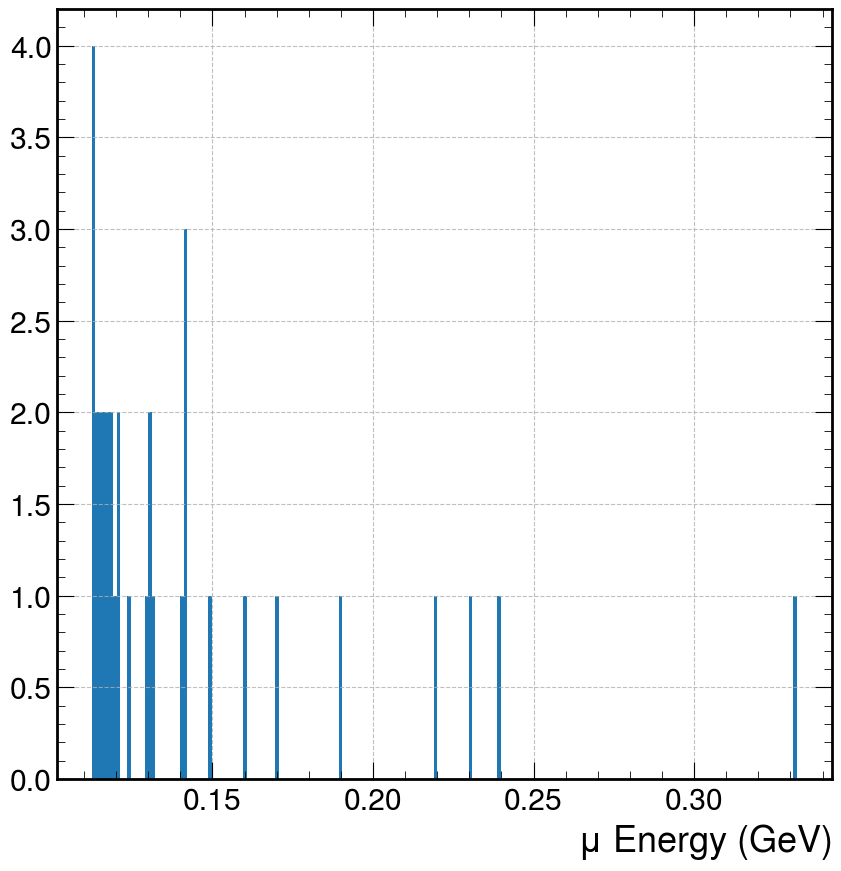

In [54]:
hist, bins = np.histogram(mu_energy_no_reco, bins=200)
# logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
logbins = 200
plt.hist(mu_energy_no_reco, bins=logbins);
plt.xlabel(r'$\mu$ Energy (GeV)')
# plt.xscale("log")
plt.show()

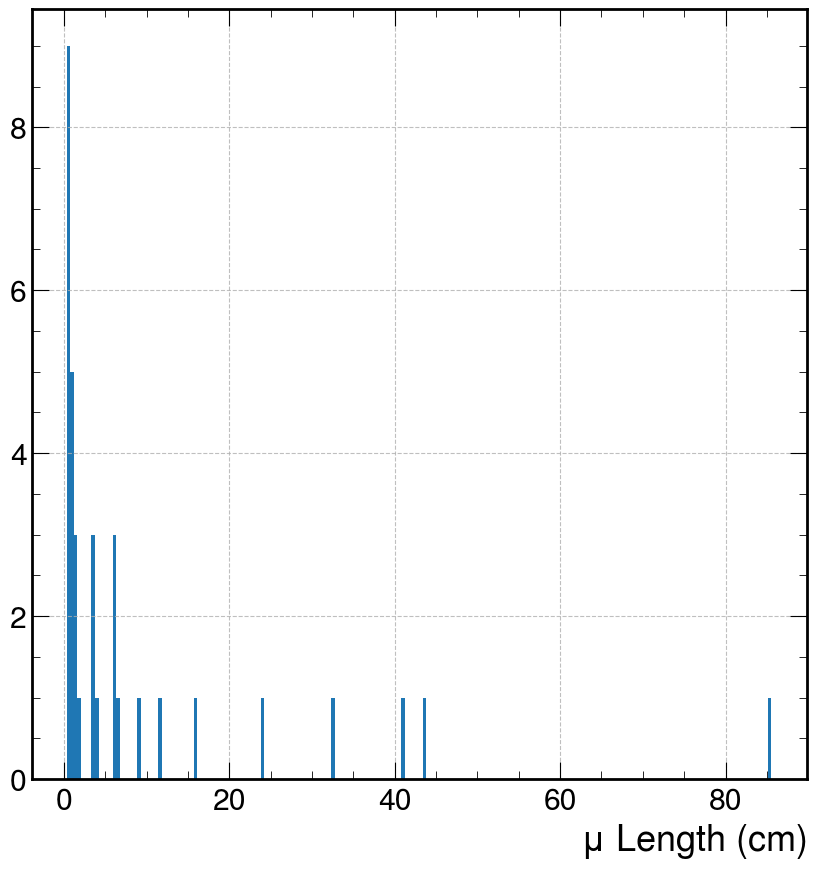

In [55]:
mu_without_tracks = abs(data_bad_reco_mu["pdg_geant"][data_bad_reco_mu["Mother_geant"] == 0]) == 13
mu_length_no_reco = data_bad_reco_mu["pathlen_drifted_geant"][mu_without_tracks][:,0]
hist, bins = np.histogram(mu_length_no_reco, bins=200)
# logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
logbins = 200
plt.hist(mu_length_no_reco, bins=logbins);
plt.xlabel(r'$\mu$ Length (cm)')
# plt.xscale("log")
plt.show()

In [30]:
for ana.ev in data_bad_reco_mu:
    ana.create_pdg_ids()
    ana.make_tree()
    print(f'event: {ana.ev["event"]}, subrun = {ana.ev.subrun}')
    ana.print_pdg_tree(mymaxlevel=2, parent_node=1, En="Eng_geant", TStart="StartT_geant", TEnd="EndT_geant", drifted_length='pathlen_drifted_geant')

event: 36, subrun = 12
1:mu- En: 0.2195 TStart: 0.0000 TEnd: 1.4818 drifted_length: 32.7140 
├── 109:gamma En: 0.0008 TStart: 1.4818 TEnd: 2.6217 drifted_length: 34.1717 
├── 110:nu(mu) En: 0.0653 TStart: 723.7357 TEnd: 837.1481 drifted_length: 202.3761 
├── 111:gamma En: 0.0045 TStart: 723.7357 TEnd: 723.9230 drifted_length: 5.6137 
├── 112:n En: 0.9428 TStart: 723.7357 TEnd: 739.2861 drifted_length: 37.6301 
├── 113:n En: 0.9421 TStart: 723.7357 TEnd: 735.3835 drifted_length: 24.4864 
├── 114:n En: 0.9406 TStart: 723.7357 TEnd: 10140.9893 drifted_length: 2508.1309 
├── 115:gamma En: 0.0008 TStart: 723.7357 TEnd: 725.4703 drifted_length: 52.0028 
└── 116:Cl37 En: 34.4251 TStart: 723.7357 TEnd: 723.7363 drifted_length: 0.0001 
event: 7, subrun = 140
1:mu- En: 0.1172 TStart: 0.0000 TEnd: 0.0923 drifted_length: 0.9111 
├── 331:gamma En: 0.0001 TStart: 0.0923 TEnd: 0.4548 drifted_length: 10.8687 
├── 332:gamma En: 0.0001 TStart: 0.0923 TEnd: 0.9002 drifted_length: 24.2211 
├── 333:e- En: 

In [48]:
n_failed_reco_mu = len(mu_energy_no_reco)
print(f'Total events cc numu: {n_numu_cc_events}')
print(f'Total events cc numu inside fiducial volume: {n_numu_cc_events_mu_contained} ({n_numu_cc_events_mu_contained/n_numu_cc_events*100:.2f}%)')
print(f'{n_failed_reco_mu} ({n_failed_reco_mu/n_numu_cc_events_mu_contained*100:.2f}%) of CC numu events (fiducial) had no track reconstructed')

Total events cc numu: 10241
Total events cc numu inside fiducial volume: 10241 (100.00%)
124 (1.21%) of CC numu events (fiducial) had no track reconstructed


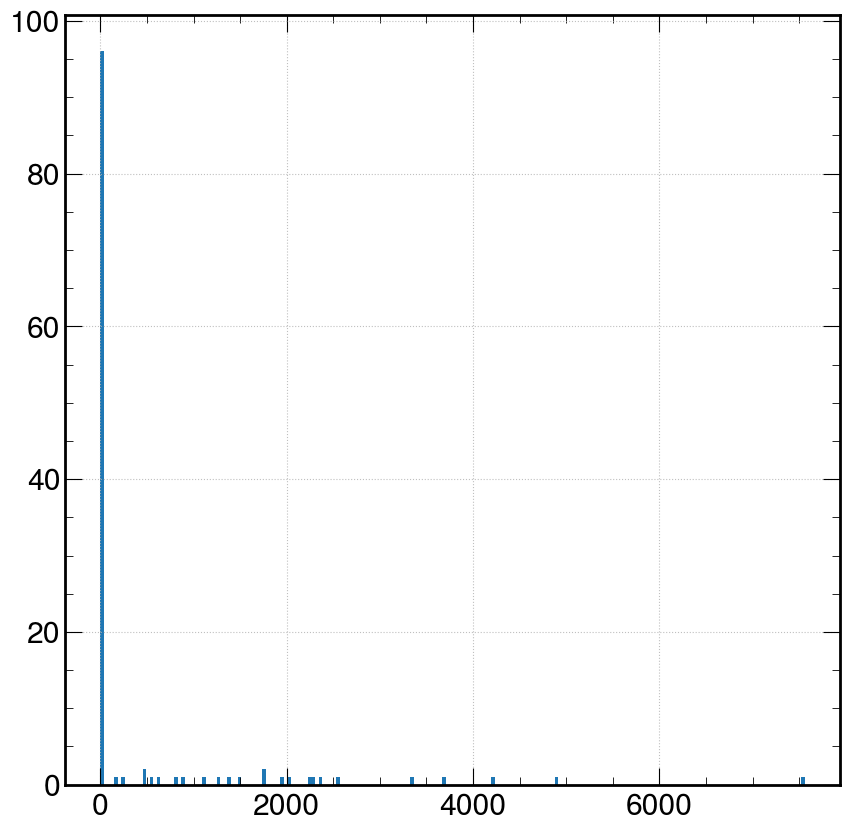

In [241]:
mu_without_tracks = abs(data_bad_reco_mu["pdg_geant"][data_bad_reco_mu["Mother_geant"] == 0]) == 13
val = data_bad_reco_mu["EndT_geant"][mu_without_tracks][:,0]
plt.hist(val, bins=200);

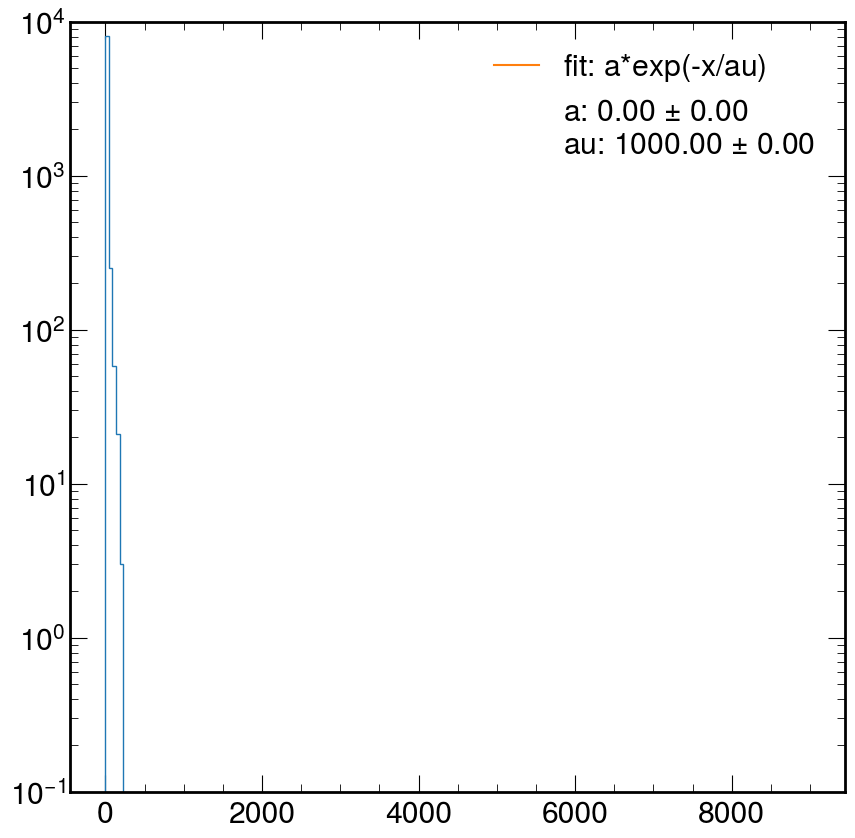

In [46]:
data_for_test = data
mask_all_mother_mu = get_mother_muon(data_for_test,pdgs=[13])
val_cut = data_for_test["EndT_geant"][mask_all_mother_mu] > -1
val = data_for_test["EndT_geant"][mask_all_mother_mu][val_cut]

val = ak.flatten(val)
def func(x, a, b):
    return a*np.exp(-x/b)

logbins = 200
plt.hist(val, bins=logbins, log=True, range=(0,9e3), histtype='step');

bins= np.linspace(0,8e3,201)
bin_heights, bin_borders = np.histogram(val, bins=bins);

plt.ylim(0.1,10000)
# bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
bin_centers = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

fitlim=200
popt, pcov = curve_fit(func, bin_centers[bin_centers>fitlim], bin_heights[bin_centers>fitlim], p0=[1,1000])
perr = np.sqrt(np.diag(pcov))
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
x_interval_for_fit = x_interval_for_fit[x_interval_for_fit>fitlim]
plt.plot(x_interval_for_fit, func(x_interval_for_fit, *popt), label='fit: a*exp(-x/$\tau$)')
label = ""
parameters = ["a", "$\tau$"]
for a, erra, pname in zip(popt, perr, parameters):
    label += f'{pname}: {a:.2f} $\pm$ {erra:.2f}\n'

fplt = plt.plot([],[],' ', label=label)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend()
# hist, bins = np.histogram(val, bins=200)
# logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

In [48]:
ana.data = data
totalevents=0
totaldecay=0
for ana.ev in ana.data[0:1000]:
    ana.create_pdg_ids()
    ana.make_tree()
    # ana.print_pdg_tree(2, node=1, startT="StartT_geant", endT="EndT_geant", E="Eng_geant", endx="EndPointx_drifted_geant")
    node:Node
    decay_modes = np.array([["e-","nu(mu)","nu(e)~"],["e+","nu(mu)~","nu(e)"]])
    decay_modes = decay_modes[0]
    if ana.pdgs[ana.nodes[1].name][0] == 13:
        print(f'{ana.ev.event}: subrun {ana.ev.subrun}')
        totalevents+=1
        for pre, _, node in RenderTree(ana.nodes[1], maxlevel=3):
            pdg_code = ana.pdgs[node.name][0]
            geant_idx = ana.pdgs[node.name][1]
            pdg_name = ana.get_pdg_name(pdg_code)
            # if pdg_name == "mu-":
            #     continue
            # print(f"{pre}{node.name}:{pdg_name}", end=" ")
            if pre != "":
                if pdg_name in decay_modes:
                    decay_modes = np.delete(decay_modes, np.where(decay_modes == pdg_name))
                    # print(decay_modes)
            # if node.name == 0:
            #     print(f"{ana.ev['enu_truth'][0]:.4f}", end=" ")
            #     print("")
            # else:
            #     print("")
            
        if(len(decay_modes) == 0):
            totaldecay+=1
            # print("Decay...")

print(f'{totaldecay}/{totalevents} = {totaldecay/totalevents}')

0:nu(mu) 50.5953 
├── 1:mu- startT: 0.0000 endT: 104.0601 
│   ├── 28737:O16 startT: 95.3786 endT: 95.3789 
│   ├── 28855:gamma startT: 104.0601 endT: 104.1749 
│   ├── 28856:gamma startT: 104.0601 endT: 104.1337 
│   ├── 28857:gamma startT: 104.0601 endT: 104.4034 
│   ├── 28858:nu(mu) startT: 136.3793 endT: 360.1859 
│   ├── 28859:gamma startT: 136.3793 endT: 137.8301 
│   ├── 28860:gamma startT: 136.3793 endT: 138.0013 
│   ├── 28861:gamma startT: 136.3793 endT: 136.5974 
│   ├── 28862:gamma startT: 136.3793 endT: 136.6592 
│   └── 28863:Al28 startT: 136.3793 endT: 136.3795 
├── 2:K- startT: 0.0000 endT: 3.3025 
│   ├── 22950:Sigma0 startT: 3.3025 endT: 3.3025 
│   ├── 22951:pi0 startT: 3.3025 endT: 3.3025 
│   ├── 22952:pi+ startT: 3.3025 endT: 18.7593 
│   ├── 22953:n startT: 3.3025 endT: 4.9295 
│   ├── 22954:n startT: 3.3025 endT: 19.5141 
│   ├── 22955:n startT: 3.3025 endT: 13.5973 
│   ├── 22956:n startT: 3.3025 endT: 5.6430 
│   ├── 22957:n startT: 3.3025 endT: 4.4530 
│   ├

In [395]:
decay_modes = np.array([["e","nu(mu)","nu(e)~"],["e+","nu(mu)~","nu(e)"]])
decay_modes = np.delete(decay_modes[0], np.where(decay_modes[0] == 'e'))
decay_modes

array(['nu(mu)', 'nu(e)~'], dtype='<U7')

In [14]:
np.sum(data["pdg_geant"][data["pdg_geant"][data["Mother_geant"] == 0] == 13] == 13)

8381

In [7]:
test = ana.idx_to_id_geant(data)

In [103]:
data["trkg4id_pandoraTrack"][:10]

<Array [[6723, 20], [1], [], [], ..., [], [], []] type='10 * var * int32'>

In [8]:
tracks_to_g4_idx = []
tracks_to_g4_pdg = []
for ev, idx in zip(data, test):
    if ev["ntracks_pandoraTrack"] != 0:
        pdg_id_of_track = ev["trkg4id_pandoraTrack"]
        pdg_idx = [idx[pdg_id][1] for pdg_id in pdg_id_of_track]
        pdg_pdg = [idx[pdg_id][0] for pdg_id in pdg_id_of_track]
        # print(ev["pdg_geant"][pdg_idx])
        # print(pdg_idx)
        tracks_to_g4_idx.append(pdg_idx)
        tracks_to_g4_pdg.append(pdg_pdg)
    else:
        # print("[]")
        tracks_to_g4_idx.append([])
        tracks_to_g4_pdg.append([])

ak.from_regular(tracks_to_g4_idx)
ak.from_regular(tracks_to_g4_pdg)


#data["pdg_id_to_idx"] = test


<Array [[2212, 2212], [11], ..., [-13, ...], [2212]] type='49900 * var * int64'>

In [9]:
data["trkg4idx_pandoraTrack"] = tracks_to_g4_idx
data["trkg4pdg_pandoraTrack"] = tracks_to_g4_pdg

In [7]:
ana.add_track_geant_info(data)

In [17]:
data = ana.data
particle_pdg = 13
def select_particle(pdg = 13):
    return abs(data["trkg4pdg_pandoraTrack"] == pdg)


# # Give me the index over geant data for particles matching the pdgcode
selection = data["trkg4idx_pandoraTrack"][select_particle(particle_pdg)]
# # mask = ana.check_fiducial(data, filter=selection,type="geant")
# # mask = [np.all(m) if len(m) != 0 else False for m in mask]

# # data = data[mask]
track_length = data["Length_pandoraTrack"][select_particle(particle_pdg)]
selection = data["trkg4idx_pandoraTrack"][select_particle(particle_pdg)]
track_length = track_length.to_list()
newselection = selection.to_list()
def Checker(reader):
    return len(np.unique(reader)) != len(reader)

# for i, (sel, lgt) in enumerate(zip(selection, track_length)):
#     if len(sel) > 1:
#         result_dict = {}
#         # if(Checker(sel)):
#         # print(f'{track_length[i]} and {sel}')
#         for idx, length in zip (sel, lgt):
            
#             # Check if the id already exists in the dictionary
#             if idx in result_dict:
#                 # If yes, accumulate the value
#                 result_dict[idx] += length
#             else:
#                 # If not, initialize the value
#                 result_dict[idx] = length
#         track_length[i] = list(result_dict.values())
#         newselection[i] = list(result_dict.keys())
#         # print(f'{track_length[i]} and {newselection[i]}')
        



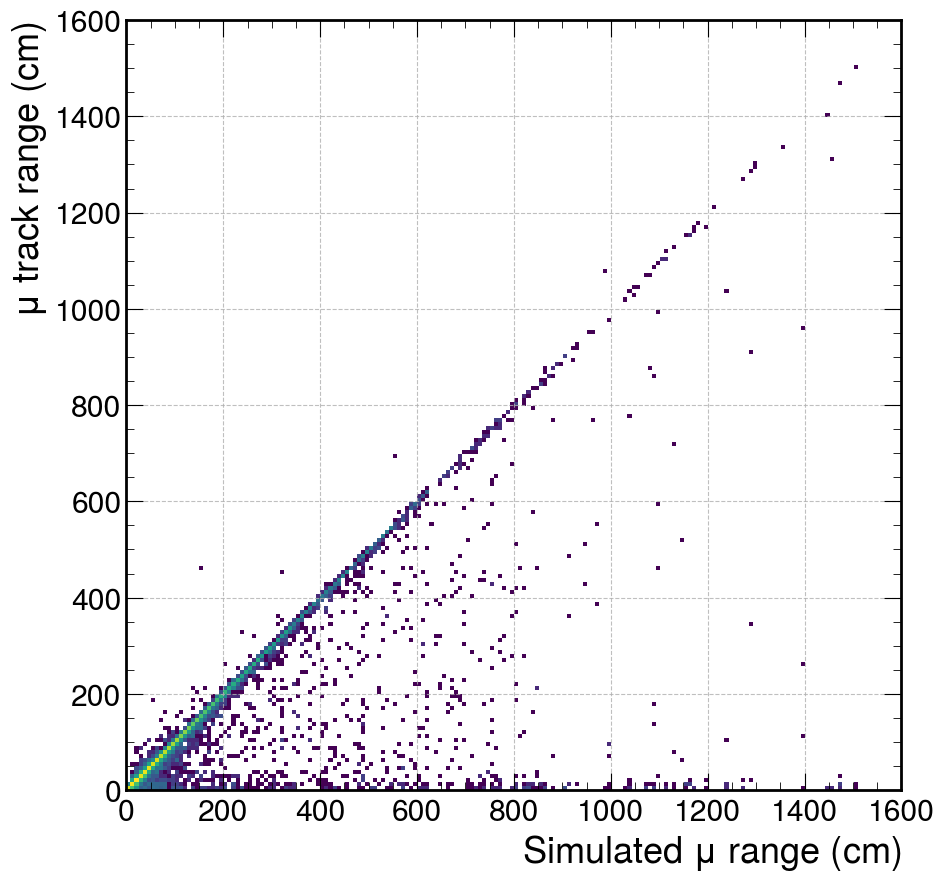

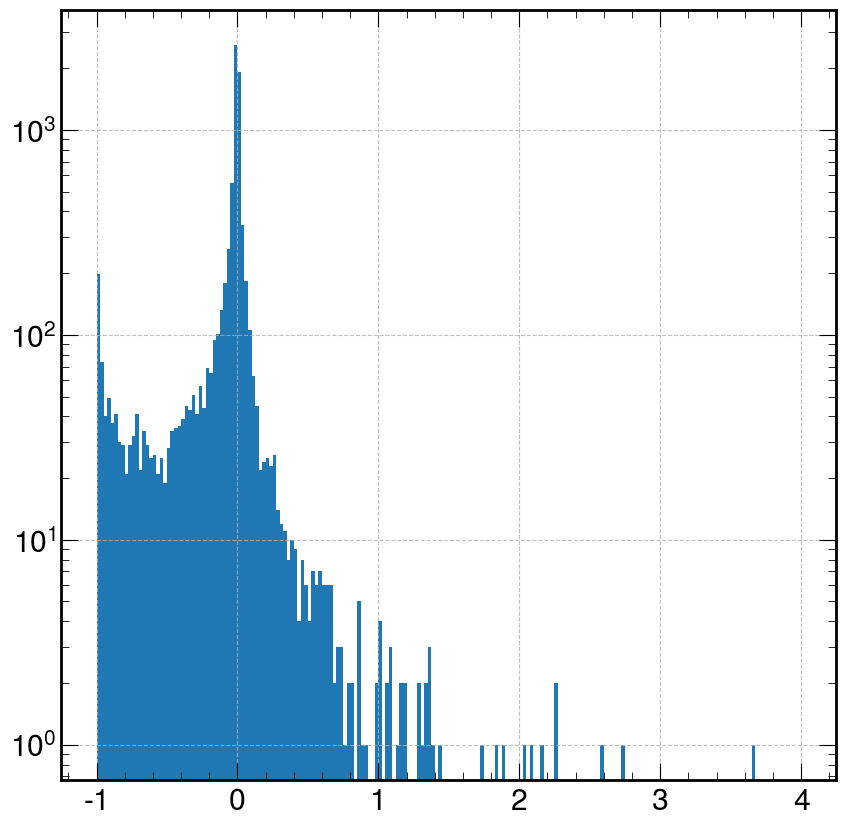

0.2965192236217047

In [18]:

track_length = ak.Array(track_length)
newselection = ak.Array(newselection)
geant_length = data["Length_geant"][newselection]

geant_length = ak.flatten(geant_length).to_numpy()
track_length = ak.flatten(track_length).to_numpy()
plt.hist2d(geant_length, track_length,bins=200, norm='log');
plt.xlabel("Simulated $\mu$ range (cm)")
plt.ylabel("$\mu$ track range (cm)")
plt.xlim(0,1600)
plt.ylim(0,1600)
plt.show()

track_distance_res = [(t-g)/g for t,g in zip(track_length,geant_length) if g != 0]
plt.hist(track_distance_res, bins=200, range=[-1,4],log=True);
plt.show()

np.std(track_distance_res)

